데이터 전처리 과정 분석

convert_h36m.py 코드를 통해 h36m_sh_conf_cam_source_final.pkl 파일로부터 clip들을 나누어 data/motion3d/MB3D_f243s81/H36M-SH 폴더에 저장함
그 과정에서 전처리 과정을 거쳐 원본 파일과 새로 생성된 파일의 값이 달라짐 -> 이 부분을 이해해야 AI Hub 데이터를 동일한 형식으로 만들어 훈련시킬 수 있음

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
os.chdir('/home/hrai/codes/PoseAdaptor')
from lib_import import *
from my_utils import *

# 주요 디렉토리 경로
user = getpass.getuser()
alphapose_root = '/home/{}/codes/AlphaPose'.format(user)
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
kookmin_root = '/home/{}/Datasets/HAAI/국민대데이터/data'.format(user)
ap_kookmin_result_root = alphapose_root + "/examples/kookmin_result_5actions"

assert os.path.isdir(alphapose_root), "AlphaPose root directory is not exist"
assert os.path.isdir(motionbert_root), "MotionBERT root directory is not exist"
assert os.path.isdir(kookmin_root), "Kookmin root directory is not exist"
assert os.path.isdir(ap_kookmin_result_root), "AlphaPose Kookmin result directory is not exist"

alphapose_root, motionbert_root, kookmin_root, ap_kookmin_result_root

('/home/hrai/codes/AlphaPose',
 '/home/hrai/codes/MotionBERT',
 '/home/hrai/Datasets/HAAI/국민대데이터/data',
 '/home/hrai/codes/AlphaPose/examples/kookmin_result_5actions')

# Total

In [3]:
root_folder = '/home/hrai/Datasets/HAAI/국민대데이터/'
subject_list = ['S01'] #['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10']
action_list = ['squat'] #['squat', 'pushup', 'kneeup', 'benchpress', 'burpee', 'butterfly', 'onehundred']
phase_list = ['001'] #['001', '002', '003']
save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/kookmin_pkl'
interpolate_spine = True

lbot = np.array([-0.53090762,  1.47796592,  0.00880748])

# fit3d origin
fit3d_example = readpkl('/home/hrai/codes/MotionBERT/data/motion3d/fit3d_pkl/s03_50591643_band_pull_apart.pkl')
trans = fit3d_example['world_3d'][0][0]
rot = Rotation.from_euler('z', -90, degrees=True).as_matrix()

In [10]:
if interpolate_spine:
    necessary_joints = [ 0, 1, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 19, 20] 
else:
    necessary_joints = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 19, 20] 

for subject in subject_list:
    for phase in phase_list:
        for action in action_list:
            # load vicon data
            file_path = os.path.join(root_folder, 'data', 'gist data', '{}/{}_{}_{}.csv'.format(subject, subject, action, phase))
            if not os.path.exists(file_path): 
                print(file_path, "no csv file")
                continue
            else:
                #print(file_path, 'exists')
                print(subject, action, phase)
            pose3d_list, attribute_list = load_pose3d_kookmin(subject, action, phase, lbot, h36m=False)  
            
            # check available frames
            available_frames, num_frames = check_available_frame(pose3d_list, necessary_joints, interpolate_spine)
            if available_frames is None: continue
            
            # convert to h36m
            pose3d_list_h36m = kookmin2h36m(pose3d_list)

            # generate pkl 
            for camera_id in ['50591643', '58860488', '60457274', '65906101']:
                _, camera_param = fit3d_load_gt_and_param(fit3d_root, camera_id)
                generate_kookmin_pkl_for_each_video(pose3d_list_h36m.copy(), available_frames.copy(), subject, camera_id, action, phase, camera_param.copy(), save_folder, trans, rot, overwrite=True)
        
            print("----------------")
            #break
        #break
    #break

S10 burpee 001
/home/hrai/Datasets/HAAI/국민대데이터/data/gist data/S10/S10_burpee_001.csv
Not enough available frames (0 frames)


In [5]:
joint_2ds = {'train': [], 'test': []}
confidences = {'train': [], 'test': []}
joint3d_images = {'train': [], 'test': []}
joints_25d_images = {'train': [], 'test': []}
_25d_factors = {'train': [], 'test': []}
camera_names = {'train': [], 'test': []}
actions = {'train': [], 'test': []}
sources = {'train': [], 'test': []}
frames = {'train': [], 'test': []}
world_3ds = {'train': [], 'test': []}
cam_3ds = {'train': [], 'test': []}
cam_params = {'train': [], 'test': []}

action_list = ['burpee'] # ['squat', 'pushup', 'kneeup', 'benchpress', 'burpee', 'butterfly', 'onehundred']
test_subject = ['S02', 'S05', 'S08'] # ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10']
pkl_folder = '/home/hrai/codes/MotionBERT/data/motion3d/kookmin_pkl'

for item in os.listdir(pkl_folder):
    subject, cam_num, action, phase = item.split('.')[0].split('_') 
    if action not in action_list: continue 
    print(subject, cam_num, action, phase) 
    item_path = os.path.join(pkl_folder, item) 
    data = readpkl(item_path) 
    #print(data.keys())
    if subject in test_subject: data_type = 'test' 
    else: data_type = 'train' 
    joint_2ds[data_type] += data['joint_2d'] 
    confidences[data_type] += data['confidence'] 
    joint3d_images[data_type] += data['joint3d_image'] 
    joints_25d_images[data_type] += data['joints_2.5d_image'] 
    _25d_factors[data_type] += data['2.5d_factor'] 
    camera_names[data_type] += data['camera_name']  
    actions[data_type] += data['action'] 
    sources[data_type] += data['source'] 
    frames[data_type] += data['frame'] 
    world_3ds[data_type] += data['world_3d'] 
    cam_3ds[data_type] += data['cam_3d'] 
    cam_params[data_type] += data['cam_param'] 
    
kookmin_total = {'train': {}, 'test': {}}

for data_type in ['train', 'test']:
    data_type_ = data_type
    kookmin_total[data_type]['joint_2d']          = copy.deepcopy(np.array(joint_2ds[data_type_]))
    kookmin_total[data_type]['confidence']        = copy.deepcopy(np.array(confidences[data_type_]))
    kookmin_total[data_type]['joint3d_image']     = copy.deepcopy(np.array(joint3d_images[data_type_]))
    kookmin_total[data_type]['joints_2.5d_image'] = copy.deepcopy(np.array(joints_25d_images[data_type_]))
    kookmin_total[data_type]['2.5d_factor']       = copy.deepcopy(np.array(_25d_factors[data_type_]))
    kookmin_total[data_type]['camera_name']       = copy.deepcopy(np.array(camera_names[data_type_]))
    kookmin_total[data_type]['action']            = copy.deepcopy(np.array(actions[data_type_]))
    kookmin_total[data_type]['source']            = copy.deepcopy(np.array(sources[data_type_]))
    kookmin_total[data_type]['frame']             = copy.deepcopy(np.array(frames[data_type_]))
    kookmin_total[data_type]['world_3d']          = copy.deepcopy(np.array(world_3ds[data_type_]))
    kookmin_total[data_type]['cam_3d']            = copy.deepcopy(np.array(cam_3ds[data_type_]))
    kookmin_total[data_type]['cam_param']         = copy.deepcopy(np.array(cam_params[data_type_]))
    
if len(kookmin_total['train']['joint_2d']) == 0:
    kookmin_total['train'] = copy.deepcopy(kookmin_total['test'])

kookmin_total['train']['joint3d_image'].shape, kookmin_total['test']['joint3d_image'].shape  

S08 65906101 burpee 001
S04 65906101 burpee 001
S04 58860488 burpee 002
S02 58860488 burpee 003
S01 65906101 burpee 002
S03 65906101 burpee 001
S05 60457274 burpee 001
S05 65906101 burpee 002
S10 60457274 burpee 002
S02 60457274 burpee 003
S09 50591643 burpee 001
S06 60457274 burpee 002
S08 50591643 burpee 002
S04 50591643 burpee 002
S02 65906101 burpee 002
S01 60457274 burpee 001
S03 65906101 burpee 002
S10 65906101 burpee 002
S03 60457274 burpee 002
S06 50591643 burpee 001
S07 60457274 burpee 002
S01 58860488 burpee 002
S03 58860488 burpee 001
S06 65906101 burpee 001
S02 50591643 burpee 002
S08 65906101 burpee 002
S07 65906101 burpee 002
S02 65906101 burpee 003
S08 60457274 burpee 002
S07 50591643 burpee 002
S09 50591643 burpee 002
S02 60457274 burpee 002
S03 50591643 burpee 001
S05 65906101 burpee 001
S04 60457274 burpee 001
S08 58860488 burpee 001
S07 65906101 burpee 001
S08 50591643 burpee 001
S09 60457274 burpee 001
S06 58860488 burpee 001
S07 60457274 burpee 001
S05 60457274 bur

((99024, 17, 3), (53804, 17, 3))

In [6]:
save_path = os.path.join(motionbert_root, 'data/motion3d/kookmin_burpee_with_fit3d_setting_s0258_test.pkl')
savepkl(kookmin_total, save_path)

# Total with kookmin camera setting

In [11]:
root_folder = '/home/hrai/Datasets/HAAI/국민대데이터/'
subject_list = ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10']
action_list = ['squat', 'pushup', 'kneeup', 'benchpress', 'burpee', 'butterfly', 'onehundred']
phase_list = ['001'] # ['001', '002', '003']
save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/kookmin_pkl_with_kookmin_setting'
if not os.path.exists(save_folder): os.makedirs(save_folder)
interpolate_spine = True
if interpolate_spine:
    necessary_joints = [ 0, 1, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 19, 20] 
else:
    necessary_joints = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 19, 20] 

lbot = np.array([-0.53090762,  1.47796592,  0.00880748])
cam_param = readpkl('/home/hrai/Datasets/HAAI/국민대데이터/camera_parameter_estimation/' + 'cam_param.pkl')

In [12]:
for subject in subject_list:
    for phase in phase_list:
        for action in action_list:
            # load vicon data
            file_path = os.path.join(root_folder, 'data', 'gist data', '{}/{}_{}_{}.csv'.format(subject, subject, action, phase))
            if not os.path.exists(file_path): 
                print(file_path, "no csv file")
                continue
            else:
                #print(file_path, 'exists')
                print(subject, action, phase)
            pose3d_list, attribute_list = load_pose3d_kookmin(subject, action, phase, lbot, h36m=False)  
            
            # check available frames
            available_frames, num_frames = check_available_frame(pose3d_list, necessary_joints, interpolate_spine)
            if available_frames is None: continue
            
            # convert to h36m
            pose3d_list_h36m = kookmin2h36m(pose3d_list)

            # generate pkl 
            for camera_id in [1, 2, 3, 4, 5, 6, 7, 8]:
                H, W, R, t, C, calibration_matrix, image = get_cam_param_kookmin(cam_param, subject, camera_id)
                camera_param = {
                    'intrinsic': calibration_matrix,
                    'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
                }
                generate_kookmin_pkl_for_each_video(pose3d_list=pose3d_list_h36m.copy(), 
                                                    available_frames=available_frames.copy(), 
                                                    subject=subject, 
                                                    camera_id=camera_id, 
                                                    action=action, 
                                                    phase=phase, 
                                                    camera_param=camera_param.copy(), 
                                                    save_folder=save_folder, 
                                                    trans=None, 
                                                    rot=None, 
                                                    centered_root=True,
                                                    overwrite=False)
        
            print("----------------")
        #break
    #break

S01 squat 001
/home/hrai/Datasets/HAAI/국민대데이터/data/gist data/S01/S01_squat_001.csv
Available frames: 0 ~ 1854
S01_1_squat.pkl exists


  0%|          | 0/1855 [00:00<?, ?it/s]

weights [1.9283899068832397, 1.9283899068832397, 1.9283899068832397, 1.9283899068832397, 1.9283899068832397, 1.9283899068832397, 1.9283899068832397, 1.9283899068832397, 1.9283899068832397]
losses [1860.269287109375, 1860.269287109375, 1860.269287109375, 1860.269287109375, 1860.269287109375, 1860.269287109375, 1860.269287109375, 1860.269287109375, 1860.269287109375]
----------------


In [ ]:
weights [1.9089199304580688, 1.9187029600143433, 1.9235703945159912, 1.9259920120239258, 1.927196979522705, 1.9277963638305664, 1.9280946254730225, 1.9282430410385132, 1.9283168315887451]
losses [1898.7435302734375, 1869.79345703125, 1862.6273193359375, 1860.853271484375, 1860.4140625, 1860.3052978515625, 1860.2783203125, 1860.2716064453125, 1860.2698974609375]

weights [1.89244544506073, 1.9105063676834106, 1.919492244720459, 1.9239630699157715, 1.9261873960494995, 1.927294135093689, 1.927844762802124, 1.9281187057495117, 1.9282550811767578]
losses [1991.3990478515625, 1892.7294921875, 1868.3045654296875, 1862.258544921875, 1860.7620849609375, 1860.391357421875, 1860.29931640625, 1860.2774658203125, 1860.2711181640625]

weights [1.8954041004180908, 1.9119783639907837, 1.920224666595459, 1.9243274927139282, 1.9263687133789062, 1.927384376525879, 1.9278897047042847, 1.9281411170959473, 1.928266167640686]
losses [1970.7000732421875, 1887.6053466796875, 1867.0361328125, 1861.9447021484375, 1860.68408203125, 1860.3724365234375, 1860.2950439453125, 1860.2757568359375, 1860.2711181640625]

weights [1.9283384084701538, 1.9283642768859863, 1.9283771514892578, 1.9283835887908936, 1.9283868074417114, 1.9283883571624756, 1.9283891916275024, 1.928389549255371, 1.9283897876739502]
losses [1860.2698974609375, 1860.2694091796875, 1860.2696533203125, 1860.2694091796875, 1860.2696533203125, 1860.269775390625, 1860.269287109375, 1860.2696533203125, 1860.2698974609375]

weights [1.9283899068832397, 1.9283899068832397, 1.9283899068832397, 1.9283899068832397, 1.9283899068832397, 1.9283899068832397, 1.9283899068832397, 1.9283899068832397, 1.9283899068832397]
losses [1860.269287109375, 1860.269287109375, 1860.269287109375, 1860.269287109375, 1860.269287109375, 1860.269287109375, 1860.269287109375, 1860.269287109375, 1860.269287109375]

In [30]:
joint_2ds = {'train': [], 'test': []}
confidences = {'train': [], 'test': []}
joint3d_images = {'train': [], 'test': []}
joints_25d_images = {'train': [], 'test': []}
_25d_factors = {'train': [], 'test': []}
camera_names = {'train': [], 'test': []}
actions = {'train': [], 'test': []}
sources = {'train': [], 'test': []}
frames = {'train': [], 'test': []}
world_3ds = {'train': [], 'test': []}
cam_3ds = {'train': [], 'test': []}
cam_params = {'train': [], 'test': []}

pkl_folder = '/home/hrai/codes/MotionBERT/data/motion3d/kookmin_pkl_with_kookmin_setting'
action_list = ['squat', 'pushup', 'kneeup', 'benchpress', 'burpee', 'butterfly', 'onehundred']
test_subject = ['S02', 'S05', 'S08'] # ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10']
camera_list = [2, 3, 4, 5, 6] # [1, 2, 3, 4, 5, 6, 7, 8]
pelvis, r_hip, l_hip, torso, neck, l_shoulder, r_shoulder = 0, 1, 4, 7, 8, 11, 14
r_knee, r_ankle, l_knee, l_ankle = 2, 3, 5, 6
l_elbow, l_wrist, r_elbow, r_wrist = 12, 13, 15, 16
joint_list = [r_knee, r_ankle, l_knee, l_ankle, l_elbow, l_wrist, r_elbow, r_wrist] # [j for j in range(17)]
only_test = False

blacklist = [
    'S03_burpee_1', 'S03_kneeup_1', 'S03_pushup_1', 'S03_squat_1', # no wide view
    'S04_burpee_2', 'S04_kneeup_2', 'S04_pushup_2', 'S04_squat_2', # no wide view
    'S04_burpee_4', 'S04_kneeup_4', 'S04_pushup_4', 'S04_squat_4', # no wide view
]

for item in os.listdir(pkl_folder):
    subject, cam_num, action, phase = item.split('.')[0].split('_') 
    
    # filtering
    if action not in action_list: continue 
    if int(cam_num) not in camera_list: continue
    if only_test:
        if subject not in test_subject: continue
    if subject in blacklist: continue
    #print(subject, cam_num, action, phase) 
    
    item_path = os.path.join(pkl_folder, item) 
    data = readpkl(item_path) 
    if subject in test_subject: data_type = 'test' 
    else: data_type = 'train' 
    
    joint_2ds[data_type] += list(np.array(data['joint_2d'])[:, joint_list]) 
    confidences[data_type] += list(np.array(data['confidence'])[:, joint_list]) 
    joint3d_images[data_type] += list(np.array(data['joint3d_image'])[:, joint_list]) 
    joints_25d_images[data_type] += list(np.array(data['joints_2.5d_image'])[:, joint_list]) 
    _25d_factors[data_type] += data['2.5d_factor'] 
    camera_names[data_type] += data['camera_name']  
    actions[data_type] += data['action'] 
    sources[data_type] += data['source'] 
    frames[data_type] += data['frame'] 
    world_3ds[data_type] += list(np.array(data['world_3d'])[:, joint_list]) 
    cam_3ds[data_type] += list(np.array(data['cam_3d'])[:, joint_list])
    cam_params[data_type] += data['cam_param'] 
    
kookmin_total = {'train': {}, 'test': {}}

for data_type in ['train', 'test']:
    kookmin_total[data_type]['joint_2d']          = copy.deepcopy(np.array(joint_2ds[data_type]))
    kookmin_total[data_type]['confidence']        = copy.deepcopy(np.array(confidences[data_type]))
    kookmin_total[data_type]['joint3d_image']     = copy.deepcopy(np.array(joint3d_images[data_type]))
    kookmin_total[data_type]['joints_2.5d_image'] = copy.deepcopy(np.array(joints_25d_images[data_type]))
    kookmin_total[data_type]['2.5d_factor']       = copy.deepcopy(np.array(_25d_factors[data_type]))
    kookmin_total[data_type]['camera_name']       = copy.deepcopy(np.array(camera_names[data_type]))
    kookmin_total[data_type]['action']            = copy.deepcopy(np.array(actions[data_type]))
    kookmin_total[data_type]['source']            = copy.deepcopy(np.array(sources[data_type]))
    kookmin_total[data_type]['frame']             = copy.deepcopy(np.array(frames[data_type]))
    kookmin_total[data_type]['world_3d']          = copy.deepcopy(np.array(world_3ds[data_type]))
    kookmin_total[data_type]['cam_3d']            = copy.deepcopy(np.array(cam_3ds[data_type]))
    kookmin_total[data_type]['cam_param']         = copy.deepcopy(np.array(cam_params[data_type]))
    
if len(kookmin_total['train']['joint_2d']) == 0:
    kookmin_total['train'] = copy.deepcopy(kookmin_total['test'])

kookmin_total['train']['joint3d_image'].shape, kookmin_total['test']['joint3d_image'].shape  

((239740, 8, 3), (103130, 8, 3))

IndexError: index 8 is out of bounds for axis 0 with size 8

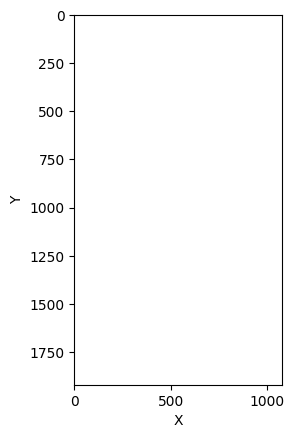

In [31]:
%matplotlib inline
fig = plt.figure(0)
fig.clear()
ax = axes_2d(fig, H=1920, W=1080)
img = get_2d_pose_image(kookmin_total['test']['joint_2d'][-1], H=1920, W=1080)
ax.imshow(img)
plt.show()

In [32]:
save_path = os.path.join(motionbert_root, 'data/motion3d/kookmin_only_appendage_with_kookmin_setting_s0258_test.pkl')
savepkl(kookmin_total, save_path)

### Change gt pose2d to ap pose2d (to be continue)

In [24]:
target_pkl = os.path.join(motionbert_root, 'data/motion3d/kookmin_total_with_kookmin_setting_s0258_test.pkl')
src = readpkl(target_pkl)

In [29]:
src.keys(), src['train'].keys(), src['test'].keys()

(dict_keys(['train', 'test']),
 dict_keys(['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source', 'frame', 'world_3d', 'cam_3d', 'cam_param']),
 dict_keys(['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source', 'frame', 'world_3d', 'cam_3d', 'cam_param']))

In [28]:
src['test']['frame']

array([   0,    1,    2, ..., 1915, 1916, 1917])

In [34]:
joint_2ds = {'train': [], 'test': []}
confidences = {'train': [], 'test': []}
joint3d_images = {'train': [], 'test': []}
joints_25d_images = {'train': [], 'test': []}
_25d_factors = {'train': [], 'test': []}
camera_names = {'train': [], 'test': []}
actions = {'train': [], 'test': []}
sources = {'train': [], 'test': []}
frames = {'train': [], 'test': []}
world_3ds = {'train': [], 'test': []}
cam_3ds = {'train': [], 'test': []}
cam_params = {'train': [], 'test': []}

action_list = ['squat', 'pushup', 'kneeup', 'benchpress', 'burpee', 'butterfly', 'onehundred']
test_subject = ['S02', 'S05', 'S08'] # ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10']
camera_list = [1, 2, 3, 4, 5, 6, 7, 8]
pkl_folder = '/home/hrai/codes/MotionBERT/data/motion3d/kookmin_pkl_with_kookmin_setting'

for item in os.listdir(pkl_folder):
    subject, camera_id, action, phase = item.split('.')[0].split('_') 
    if action not in action_list: continue 
    if subject not in test_subject: continue
    if int(camera_id) not in camera_list: continue
    print(subject, camera_id, action, phase) 
    item_path = os.path.join(pkl_folder, item) 
    data = readpkl(item_path) 
    #print(data.keys())
    if subject in test_subject: data_type = 'test' 
    else: data_type = 'train' 
    if data_type == 'train': 
        joint_2ds[data_type] += data['joint_2d'] 
    elif data_type == 'test':
        # load 
        ap_result_path = os.path.join(ap_kookmin_result_root, 'res_{}_{}_{}'.format(subject, action, camera_id))
        video_path = '/home/hrai/Datasets/HAAI/국민대데이터/data/videos/{}/{}_{}_{}.mp4'.format(subject, subject, action, camera_id) 
        joint_2d = get_ap_pose_2d(video_path, ap_result_path)
        print(len(joint_2d), len(data['joint_2d']))
    confidences[data_type] += data['confidence'] 
    joint3d_images[data_type] += data['joint3d_image'] 
    joints_25d_images[data_type] += data['joints_2.5d_image'] 
    _25d_factors[data_type] += data['2.5d_factor'] 
    camera_names[data_type] += data['camera_name']  
    actions[data_type] += data['action'] 
    sources[data_type] += data['source'] 
    frames[data_type] += data['frame'] 
    world_3ds[data_type] += data['world_3d'] 
    cam_3ds[data_type] += data['cam_3d'] 
    cam_params[data_type] += data['cam_param'] 
    break
    


S05 1 burpee 001
899 1707


In [ ]:
kookmin_total = {'train': {}, 'test': {}}

for data_type in ['train', 'test']:
    data_type_ = data_type
    kookmin_total[data_type]['joint_2d']          = copy.deepcopy(np.array(joint_2ds[data_type_]))
    kookmin_total[data_type]['confidence']        = copy.deepcopy(np.array(confidences[data_type_]))
    kookmin_total[data_type]['joint3d_image']     = copy.deepcopy(np.array(joint3d_images[data_type_]))
    kookmin_total[data_type]['joints_2.5d_image'] = copy.deepcopy(np.array(joints_25d_images[data_type_]))
    kookmin_total[data_type]['2.5d_factor']       = copy.deepcopy(np.array(_25d_factors[data_type_]))
    kookmin_total[data_type]['camera_name']       = copy.deepcopy(np.array(camera_names[data_type_]))
    kookmin_total[data_type]['action']            = copy.deepcopy(np.array(actions[data_type_]))
    kookmin_total[data_type]['source']            = copy.deepcopy(np.array(sources[data_type_]))
    kookmin_total[data_type]['frame']             = copy.deepcopy(np.array(frames[data_type_]))
    kookmin_total[data_type]['world_3d']          = copy.deepcopy(np.array(world_3ds[data_type_]))
    kookmin_total[data_type]['cam_3d']            = copy.deepcopy(np.array(cam_3ds[data_type_]))
    kookmin_total[data_type]['cam_param']         = copy.deepcopy(np.array(cam_params[data_type_]))
    
if len(kookmin_total['train']['joint_2d']) == 0:
    kookmin_total['train'] = copy.deepcopy(kookmin_total['test'])

kookmin_total['train']['joint3d_image'].shape, kookmin_total['test']['joint3d_image'].shape  